# TODO
1. 把下面的优化代码跑通
2. 调整参数，包括回测周期，win, decay, coef, topn, maxweight, lmd，获得300增强、500增强、1000增强下的调优
3. 增加换手限制
4. 增加行业风格限制

In [90]:
from scipy.optimize import minimize
import seaborn as sns
from typing import List
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [91]:
class Backtest: # 策略回测
    def __init__(self, w: pd.DataFrame, ret: pd.DataFrame, 
            startdate: str=None, enddate: str=None):
        '''
        设置权重和收益率序列，序列的索引必须为DatetimeIndex，并按日期排序。
        '''
        self.w = w.fillna(0) # 持仓权重
        # self.w.index.name = 'Date'
        self.ret = ret.fillna(0) # ret的维度是（交易日*股票数）
        self.startdate = None if startdate is None else pd.to_datetime(startdate)
        self.enddate = None if enddate is None else pd.to_datetime(enddate)
        
        self.init_asset = 1e9
        self.broadcast = True
        self.max_position = 1 # 满仓
        self.risk_free_rate = 0.015

        self.__align_index()
        
    def set_param(self, init_asset=1e9, broadcast=True, max_position=1, risk_free_rate=0.015): # 设定回测参数
        self.init_asset = init_asset
        self.broadcast = broadcast
        self.max_position = max_position
        self.risk_free_rate = risk_free_rate

    def set_duration(self, duration): # 债券中的久期
        self.duration = duration.dropna()
        self.duration = duration.reindex(index=self.ret.index)
        self.duration = self.duration.fillna(method='ffill')

    def cal_duration(self):
        bond_pos = self.position[self.duration.columns]
        weight = bond_pos / bond_pos.sum(axis=1).values.reshape(-1, 1) # 计算持仓权重
        self.portfolio_duration = (self.duration * weight).sum(axis=1)
        self.portfolio_duration.name = '组合久期'
        
    def __align_index(self):
        '''
        对齐权重和收益率序列的日期索引
        删除收益率序列最后一日之后的权重，只保留收益率序列第一日之前的最后一条权重
        '''
        firstdt = self.ret.index.min()
        lastdt = self.ret.index.max()
        ealier = self.w[self.w.index < firstdt]
        inrange = self.w[(self.w.index >= firstdt) & (self.w.index <= lastdt)]
        if len(ealier) > 0:
            self.w = self.w.loc[ealier.index[-1]:inrange.index[-1]]
        else:
            self.w = inrange
        
        idx_comb = set(self.w.index) | set(self.ret.index)
        idx_comb = list(idx_comb)
        idx_comb.sort()
        idx_comb = pd.DatetimeIndex(idx_comb, name='Date')
        self.w = self.w.reindex(index=idx_comb, columns=self.ret.columns)
        self.ret = self.ret.reindex(index=idx_comb)
        self.ret = self.ret.fillna(0)
        self.w = self.w.fillna(0)
        if self.startdate is not None:
            self.w = self.w.loc[self.startdate:]
            self.ret = self.ret.loc[self.startdate:]
        if self.enddate is not None:
            self.w = self.w.loc[:self.enddate]
            self.ret = self.ret.loc[:self.enddate]
        
    def cal_portfolio_rtn(self): # 计算自融资portfolio的netvalue和return，都是矩阵形式的
        
        self.position = np.zeros_like(self.ret) # 各个股票的仓位（价值）
        self.portfolio_ret = np.zeros(self.ret.shape[0])
        self.portfolio_value = np.zeros(self.ret.shape[0])
        self.cash = np.zeros(self.ret.shape[0])
        self.tvrvalue = np.zeros(self.ret.shape[0])
        self.ret_contr = np.zeros_like(self.ret)
        w = self.w.values
        ret = self.ret.values
        
        if np.all(w[0] == 0):
            self.position[0] = 0
            self.cash[0] = self.init_asset
        else:
            self.position[0] = self.max_position * self.init_asset * w[0] / np.sum(w[0])
            self.cash[0] = self.init_asset - np.sum(self.position[0])
        self.portfolio_value[0] = np.sum(self.position[0]) + self.cash[0]
        
        # pdb.set_trace()
        for di in range(1, len(ret)):
            self.portfolio_value[di] = np.sum(self.position[di-1] * (1 + ret[di])) + self.cash[di-1]
            
            empty = np.all(w[di] == 0)
            if empty and self.broadcast:
                self.position[di] = self.position[di-1] * (1 + ret[di]) # 资产的价值
                self.cash[di] = self.cash[di-1] # cash的价值
                self.tvrvalue[di] = 0 # 换手资产的价值
            elif empty:
                self.position[di] = 0
                self.cash[di] = self.position[di-1] * (1 + ret[di]) + self.cash[di-1]
                self.tvrvalue[di] = np.sum(self.position[di-1] * (1 + ret[di]))
            else:
                self.position[di] = self.max_position * self.portfolio_value[di] * w[di] / np.sum(w[di])
                self.cash[di] = self.portfolio_value[di] - np.sum(self.position[di])
                self.tvrvalue[di] = np.sum(np.abs(self.position[di] - self.position[di-1] * (1 + ret[di])))
                
            self.portfolio_ret[di] = self.portfolio_value[di] / self.portfolio_value[di-1] - 1
            self.ret_contr[di] = self.position[di-1] * ret[di] / self.portfolio_value[di-1]
            
        self.portfolio_value = pd.Series(self.portfolio_value, index=self.ret.index, name='portfolio_value')
        self.portfolio_ret = pd.Series(self.portfolio_ret, index=self.ret.index, name='portfolio_ret')
        self.ret_contr = pd.DataFrame(self.ret_contr, index=self.ret.index, columns=self.ret.columns)
        self.position = pd.DataFrame(self.position, index=self.ret.index, columns=self.ret.columns)

    def cal_risk_contr(self):
        '''
        计算各资产的风险贡献
        将各资产乘以对应权重作为一个单独资产，组合收益率可以看做赋权资产的等权组合。由此计算各资产的实际风险贡献
        '''
        # 等权组合的各资产权重为1/N
        # r_p = Σ r_i = 1/N Σ r_{new, i}
        # r_{new, i} = N * r_i
        N = self.ret_contr.shape[1]
        ret = self.ret_contr * N
        cov_matrix = ret.cov()
        weights = np.ones(N) / N
        sigma_p = np.sqrt( weights @ cov_matrix @ weights )
        beta = (weights @ cov_matrix) / sigma_p**2
        mc = sigma_p * weights * beta
        mc_pct = mc / sigma_p
        self.risk_contribution = mc_pct[mc_pct != 0]
    
    def stats(self): # 计算portfolio的相关指标
        self.nav = (1 + self.portfolio_ret).cumprod()
        self.nav.name = '组合净值'
        self.cumret = self.nav.iloc[-1] - 1
        self.ret_year = self.nav.iloc[-1] ** (250 / len(self.nav)) - 1
        self.ir = self.portfolio_ret.mean() / self.portfolio_ret.std() * 250**0.5
        rfr_daily = (1 + self.risk_free_rate) ** (1 / 250) - 1 # 无风险利率
        self.sharpe_ratio = (self.portfolio_ret.mean() - rfr_daily) / self.portfolio_ret.std() * 250**0.5
        maxnav = self.nav.cummax()
        drawdown = -(self.nav / maxnav - 1)
        self.drawdown = -drawdown
        self.maxdd = drawdown.max()
        self.dd_end = drawdown.idxmax()
        self.dd_start = maxnav[maxnav == maxnav[self.dd_end]].index[0]
        self.tvr = (self.tvrvalue / self.portfolio_value).mean() * 125 # 换手率
        self.volatility = self.portfolio_ret.std() * 250**0.5
        self.cal_risk_contr()
        self.statistics = NAVStat(self.nav, risk_free_rate=self.risk_free_rate).stats(False)
    
    def show(self):
        if hasattr(self, 'portfolio_duration'):
            fig, ax1 = plt.subplots(figsize=(10, 5))
            color = 'tab:blue'
            ax1.set_xlabel('日期')
            ax1.set_ylabel(self.nav.name, color=color)
            ax1.plot(self.nav.index, self.nav.values, label=self.nav.name, color=color)
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'tab:red'
            ax2.set_ylabel('组合久期', color=color)  # we already handled the x-label with ax1
            ax2.plot(self.portfolio_duration.index, self.portfolio_duration.values, color=color)
            ax2.tick_params(axis='y', labelcolor=color)
            ax2.grid(False)

            fig.tight_layout()
        else:
            fig, ax1 = plt.subplots(figsize=(10, 5))
            self.nav.plot(ax=ax1, title='组合净值')
        print('总收益：%.2f%%' % (self.cumret * 100))
        print('年化收益：%.2f%%' % (self.ret_year * 100))
        print('年化波动率：%.2f%%' % (self.volatility * 100))
        print('夏普比率：%.2f' % self.sharpe_ratio)
        print('最大回撤：%.2f%%' % (self.maxdd * 100))
        print('最大回撤区间: {} - {}'.format(self.dd_start.strftime('%Y%m%d'), self.dd_end.strftime('%Y%m%d')))
        # print('各资产风险贡献：\n')
        # print(self.risk_contribution)
        
    def run(self):
        self.cal_portfolio_rtn()
        self.cal_risk_contr()
        self.stats()
        self.show()


class NAVStat: # 计算净值，在Backtest中用到
    def __init__(self, nav: pd.Series, isret: bool=False, tdays: int=250, risk_free_rate: float=0.0):
        if isret:
            self.ret = nav.fillna(0)
            if self.ret.iloc[0] != 0:
                index = [self.ret[0] - pd.Timedelta(days=1)] + self.ret.index.to_list()
                index = pd.Index(index, name='DATE')
                self.ret = self.ret.reindex(index=index).fillna(0)
            self.nav = (self.ret + 1).cumprod()
        else:
            self.nav = nav / nav.iloc[0]
            self.ret = nav.pct_change().fillna(0)

        self.TradingDaysofYear = tdays
        self.risk_free_rate = risk_free_rate

    def cal_nav_stat(self, nav: pd.Series):
        ret = nav.pct_change()
        cumret = nav.iloc[-1] / nav.iloc[0] - 1
        ret_year = (cumret + 1) ** (self.TradingDaysofYear / len(nav)) - 1
        ir = ret.mean() / ret.std() * self.TradingDaysofYear**0.5
        rfr_daily = (1 + self.risk_free_rate) ** (1 / self.TradingDaysofYear) - 1
        sharpe_ratio = (ret.mean() - rfr_daily) / ret.std() * 250**0.5
        maxnav = nav.cummax()
        drawdown = -(nav / maxnav - 1)
        maxdd = drawdown.max()
        dd_end = drawdown.idxmax()
        dd_start = maxnav[maxnav == maxnav[dd_end]].index[0]
        dd_period = dd_start.strftime('%Y%m%d') + ' - ' + dd_end.strftime('%Y%m%d')
        volatility = ret.std() * self.TradingDaysofYear**0.5
        res = pd.Series([cumret, ret_year, volatility, sharpe_ratio, maxdd, dd_period], 
            index=['收益', '年化收益', '波动率', '夏普率', '最大回撤', '最大回撤区间'])
        return res

    def stats(self, plot=True):
        years = np.array([x.year for x in self.nav.index])
        year_uni = np.unique(years)
        res = []
        for ii, y in enumerate(year_uni):
            nav_part = self.nav[years == y]
            if ii == 0 and len(nav_part) < 2:
                continue
            if ii != 0:
                nav_part = pd.concat([self.nav[years == y-1].iloc[-1:], nav_part])
            year_stat = self.cal_nav_stat(nav_part)
            year_stat.name = str(y)
            res.append(year_stat)
        all_stat = self.cal_nav_stat(self.nav)
        all_stat.name = 'all'
        res.append(all_stat)
        res = pd.concat(res, axis=1).T
        res.index.name = 'year'
        self.statistics = res

        if plot:
            fig, ax = plt.subplots(figsize=(10, 5))
            self.nav.plot(ax=ax, title='NV')

        return res

In [4]:
def cal_track_err(ret1, ret2): # 两个时间序列的简单跟踪误差
    trackerr = np.std(ret1 - ret2) * 250**0.5
    return trackerr

def cal_track_err_w(ret1, ret2, w): # 带有权重的跟踪误差
    track_diff = ret1 - ret2
    var_w = w @ (track_diff ** 2)
    track_err = np.sqrt(var_w) * 250**0.5
    return track_err

def cal_decay_w(N, decay, coef): # 生成衰减权重，包括exp和linnear两种方式
    if decay == 'exp':
        w = (1 - coef) * coef ** np.arange(N-1, -1, -1)
    if decay == 'linear':
        w = np.linspace(coef, 1, N)
    
    w = w / np.sum(w)
    return w

def cal_track_err_decay(ret1, ret2, decay='exp', coef=0.97):
    if decay not in ('exp', 'linear', None):
        raise ValueError('衰减方式错误！')
    if decay is None:
        return cal_track_err(ret1, ret2)
    else:
        w = cal_decay_w(len(ret1), decay, coef)
        return cal_track_err_w(ret1, ret2, w)

In [5]:
'''
回测时的各种约束条件
'''
def total_weight_constraint(x): # 持仓总权重为1
    return np.sum(x) - 1.

def long_only_constraint(x): # 只能做多
    return x

def linear_constraint(x, v, const):
    return x @ v - const # @表示矩阵乘法

def individual_constraint(x, const, larger=True): # 个股权重限制
    if larger:
        return x - const
    else:
        return -x + const
    
# 跟踪误差约束条件（maxerr），ptf_ret为投资组合收益，iret为基准收益   
def track_err_constraint(x, fret, iret, decay, maxerr, errtype='abs'):
    ptf_ret = fret @ x # 资产收益 * 持仓权重 = 组合收益的时间序列
    track_err = cal_track_err_w(ptf_ret, iret, decay)
    
    if errtype == 'abs':
        return maxerr - track_err
    else:
        ivol = np.std(iret) * 250 ** 0.5
        return ivol * maxerr - track_err

def clean_weight(x, threshhold=0.0001): # 清理掉持仓权重太小的股票
    y = x.copy()
    y[np.abs(x) < threshhold] = 0
    y = y / np.sum(np.abs(y))
    return y

def risk_model_objective(x, fac_ret, cov_matrix, risk_aver): # 这里需要Barra的协方差矩阵数据
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    J = -(x @ fac_ret - risk_aver * x @ cov_matrix @ x)
    return J

def add_sec_constr(constraints, sec_exposure, sec_ub):
    for col in sec_exposure.columns:
        constraints.append(
            {'type': 'ineq', 'fun': linear_constraint, 'args': (-sec_exposure[col].values, -sec_ub)}
        )

In [6]:
def track_err_objective(x, funds_ret, index_ret, decay=None, coef=None): # 计算跟踪误差，是一个需要最小化的目标函数
    
    ptf_ret = funds_ret @ x
    J = cal_track_err_decay(ptf_ret, index_ret, decay=decay, coef=coef)
    return J

In [7]:
def enhanced_fof_objective(x, funds_ret, index_ret, decay, facval, lmd): # 定义目标函数，最小化跟踪误差，最大化因子暴露，lmd是超参
   
    ptf_ret = funds_ret @ x
    track_err = cal_track_err_w(ptf_ret, index_ret, decay)
    fac_expo = facval @ x
    J = track_err - lmd * fac_expo

    return J

In [8]:
def expo_objective(x, facval): # 定义目标函数，最大化因子暴露
    J = -facval @ x
    return J

In [9]:
# track_err_constraint的同时minimize expo_objective计算持仓权重
def gen_opt_weights_maxexpo(fundret, idxret, factor, reb_date, universe=None, win=120, topn=100, maxweight=0.05, decay='exp', coef=0.98, maxerr=0.04, errtype='abs'):
    if decay is not None:
        decay = cal_decay_w(win, decay, coef)
        
    dimap = dict(zip(fundret.index, range(len(fundret))))

    constraints = [
        {'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint},
        {'type': 'ineq', 'fun': individual_constraint, 'args': (maxweight, False)}
    ]
    
    weight = []
    trackerr = []
    facexpo = []
    for opday in reb_date:
        # 从前win天到前1天
        day0 = fundret.index[dimap[opday] - win]
        day1 = fundret.index[dimap[opday] - 1]
        if universe is not None:
            facval = (factor.loc[day1] * universe.loc[opday]).dropna() # facval是day1的alpha向量
        else:
            facval = factor.loc[day1].dropna()
        facval = (facval - facval.mean()) / facval.std()
        facval = facval.sort_values(ascending=False).head(topn) # 选择day1中alpha最大的top100的股票
        fret = fundret.loc[day0:day1, facval.index].fillna(0)
        iret = idxret.loc[day0:day1]
        w0 = np.ones(len(facval)) / len(facval)
        
        constraints_day = constraints + [{'type': 'ineq', 'fun': track_err_constraint, 'args': (fret, iret, decay, maxerr, errtype)}]
        # SLSQP算法是一种基于梯度的优化算法，它期望目标和约束的导数是连续的
        res = minimize(expo_objective, w0, 
                       args=(facval,), method='SLSQP', 
                       constraints=constraints_day, tol=1e-10) # 在限制条件下最小化目标函数
        op_w = pd.Series(clean_weight(res.x), index=facval.index) # 经过优化后的持仓权重
        print(opday.strftime('%Y-%m-%d'), len(op_w[op_w > 0]), -res.fun)
        weight.append(op_w)
        facexpo.append(-res.fun) # 因子暴露
        trackerr.append(cal_track_err_w(fret @ res.x, iret, decay)) # 跟踪误差
        
    weight = pd.concat(weight, axis=1).T
    weight.index = reb_date
    weight = weight.fillna(0)
    trackerr = pd.Series(trackerr, index=reb_date, name='trackerr')
    facexpo = pd.Series(facexpo, index=reb_date, name='facexpo')
    info = pd.concat([trackerr, facexpo], axis=1)
    
    
    return weight, info

In [10]:
# 根据minimize track_err_objective计算持仓权重
def gen_opt_weights(fundret, idxret, factor, reb_date, universe=None, win=120, topn=100, maxweight=0.05, decay='exp', coef=0.98):
    if decay is not None:
        decay = cal_decay_w(win, decay, coef)
        
    dimap = dict(zip(fundret.index, range(len(fundret))))

    constraints = [
        {'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint},
        {'type': 'ineq', 'fun': individual_constraint, 'args': (maxweight, False)}
    ]
    
    weight = []
    trackerr = []
    for opday in reb_date:
        day0 = fundret.index[dimap[opday] - win]
        day1 = fundret.index[dimap[opday] - 1]
        if universe is not None:
            facval = (factor.loc[day1] * universe.loc[opday]).dropna()
        else:
            facval = factor.loc[day1].dropna()
        facval = (facval - facval.mean()) / facval.std()
        facval = facval.sort_values(ascending=False).head(topN)
        fret = fundret.loc[day0:day1, facval.index].fillna(0)
        iret = idxret.loc[day0:day1]
        w0 = np.ones(len(facval)) / len(facval)
        
        res = minimize(track_err_objective, w0, 
                       args=(fret, iret, decay, coef), method='SLSQP', 
                       constraints=constraints, tol=1e-14)
        op_w = pd.Series(clean_weight(res.x), index=facval.index)
        print(opday.strftime('%Y-%m-%d'), len(op_w[op_w > 0]), res.fun)
        weight.append(op_w)
        trackerr.append(res.fun)
        
    weight = pd.concat(weight, axis=1).T
    weight.index = reb_date
    weight = weight.fillna(0)
    trackerr = pd.Series(trackerr, index=reb_date)
    
    return weight, trackerr

In [11]:
# 根据minimize enhanced_fof_objective计算持仓权重，这是我们最终所选择的方式
def gen_opt_weights_mix(fundret, idxret, factor, reb_date, universe=None, win=120, topn=100, maxweight=0.05, decay='exp', coef=0.98, lmd=0.04):
    if decay is not None:
        decay = cal_decay_w(win, decay, coef)
        
    dimap = dict(zip(fundret.index, range(len(fundret))))

    constraints = [
        {'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint},
        {'type': 'ineq', 'fun': individual_constraint, 'args': (maxweight, False)}
    ]
    
    weight = []
    trackerr = []
    facexpo = []
    for opday in reb_date:

        day0 = fundret.index[dimap[opday] - win]
        day1 = fundret.index[dimap[opday] - 1]
        if universe is not None:
            facval = (factor.loc[day1] * universe.loc[opday]).dropna()
        else:
            facval = factor.loc[day1].dropna()
        facval = (facval - facval.mean()) / facval.std()
        facval = facval.sort_values(ascending=False).head(topn)
        fret = fundret.loc[day0:day1, facval.index].fillna(0)
        iret = idxret.loc[day0:day1]
        w0 = np.ones(len(facval)) / len(facval)
        
        res = minimize(enhanced_fof_objective, w0, 
                       args=(fret, iret, decay, facval, lmd), method='SLSQP', 
                       constraints=constraints, tol=1e-10)
        op_w = pd.Series(clean_weight(res.x), index=facval.index)
        # print(opday.strftime('%Y-%m-%d'), len(op_w[op_w > 0]), res.fun)
        weight.append(op_w)
        facexpo.append(facval @ res.x)
        trackerr.append(cal_track_err_w(fret @ res.x, iret, decay))
        # print(op_w)
    weight = pd.concat(weight, axis=1).T
    weight.index = reb_date
    weight = weight.fillna(0)
    trackerr = pd.Series(trackerr, index=reb_date, name='trackerr')
    facexpo = pd.Series(facexpo, index=reb_date, name='facexpo')
    info = pd.concat([trackerr, facexpo], axis=1)
    
    return weight, info

In [79]:
class Backtest2(Backtest): # 基于原始的Backtest，添加了回测portfolio与index的跟踪误差的功能
    def benchmark(self, bench): # bench是基准，即index
        
        self.excess_nav = (self.portfolio_ret - bench + 1).dropna().cumprod() # 超额净值
        self.excess_stat = NAVStat(self.excess_nav).stats() # 对净值走势进行分析
        track_err = []
        for year in range(self.excess_nav.index[0].year, self.excess_nav.index[-1].year + 1):
            part = self.portfolio_ret[self.excess_nav.index][datetime(year, 1, 1):datetime(year, 12, 31)]
            err = cal_track_err(part, bench[part.index])
            track_err.append((str(year), err))
        
        track_err.append(('all', cal_track_err(self.portfolio_ret[self.excess_nav.index], bench[self.excess_nav.index])))
        track_err = pd.Series(dict(track_err), name='跟踪误差')
        self.excess_stat = pd.concat([self.excess_stat, track_err], axis=1)
        return self.excess_stat, self.excess_nav
        
    def run(self):
        self.cal_portfolio_rtn() # 从Backtest类继承来
        self.cal_risk_contr()
        self.stats()
        self.statistics = NAVStat(self.nav).stats()
        return self.statistics, self.nav

In [13]:
import bottleneck as bn

def winsorize(alpha, win_type='QuantileDraw', n_draw=5, pvalue=0.05): # 用相应分位数的值替代分位数之外的值
    index = alpha.index
    columns = alpha.columns
    alpha = alpha.values
    
    if not win_type in {'NormDistDraw', 'QuantileDraw'}:
        raise ValueError('win_type shall be NormDistDraw or QuantileDraw!')
    if pvalue <= 0 or pvalue >=1:
        raise ValueError('pvalue shall be in (0, 1)!')
        
    if win_type == 'NormDistDraw':
        for i in range(n_draw):
            for di in range(alpha.shape[0]):
                mean = bn.nanmean(alpha[di])
                std = bn.nanstd(alpha[di])
                up = mean + 3 * std
                down = mean - 3 * std
                mask = ~np.isnan(alpha[di])
                dimask = alpha[di, mask]
                # 将非NAN值挑选出来比较，避免warning
                mark1 = dimask > up
                mark2 = dimask < down
                dimask[mark1] = up
                dimask[mark2] = down
                alpha[di, mask] = dimask
    else:
        q1 = np.nanquantile(alpha, q=pvalue/2, axis=1)
        q2 = np.nanquantile(alpha, q=(1-pvalue/2), axis=1)
        for di in range(alpha.shape[0]):
            mask = ~np.isnan(alpha[di])
            dimask = alpha[di, mask]
            dimask[dimask < q1[di]] = q1[di]
            dimask[dimask > q2[di]] = q2[di]
            alpha[di, mask] = dimask
    res = pd.DataFrame(alpha, index=index, columns=columns)
    return res
            
    
def zscore(alpha):
    mean = bn.nanmean(alpha, axis=1)
    std = bn.nanstd(alpha, axis=1)
    res = (alpha - mean.reshape(-1, 1)) / std.reshape(-1, 1)
    return res

In [14]:
def alpha_combo(alpha_list, weight_list, universe): # 将多个alpha表组合在一起
    if len(alpha_list) != len(weight_list):
        raise RuntimeError('alpha and weight list length not match, alpha=%s, weight=%s'%(len(alpha_list), len(weight_list)))
    
    alpha_clean_list = []
    length = len(alpha_list)
    for i in range(length):
        alpha = alpha_list[i].copy()
        weight = weight_list[i]
        alpha = winsorize(alpha)
        alpha = zscore(alpha)
        alpha = alpha.fillna(0.0)
        alpha_clean_list.append(alpha)
        
    res = alpha_clean_list[0].copy() * weight_list[0]
    if length > 1:
        for i in range(1, length):
            res += alpha_clean_list[i] * weight_list[i]
    
    res = res * universe
    res = zscore(res)
            
    return res

In [15]:
def nan_max(row):
    return np.nanmax(list(row.values))
def nan_min(row):
    return np.nanmin(list(row.values))
def nan_quantile(row, q):
    return np.nanquantile(list(row.values), q)
def nan_mean(row):
    return np.nanmean(list(row.values))

def calc_alpha_daily_stats(alpha):
    stats = pd.DataFrame(index=alpha.index)
    stats['ValidNum'] = alpha.count(axis=1).values
    stats['Max'] = alpha.apply(nan_max, axis=1).values
    stats['Q0.975'] = alpha.apply(nan_quantile, args=(0.975,), axis=1).values
    stats['Q0.5'] = alpha.apply(nan_quantile, args=(0.5,), axis=1).values
    stats['Q0.025'] = alpha.apply(nan_quantile, args=(0.025,), axis=1).values
    stats['Min'] = alpha.apply(nan_min, axis=1).values
    stats['Mean'] = alpha.apply(nan_mean, axis=1).values
    return stats

def test_alpha_dict(alpha_dict): # 对alpha表进行数据可视化
    for alpha_name, alpha in alpha_dict.items():
        stats = calc_alpha_daily_stats(alpha)
        print('==' * 30)
        print(alpha_name)
        print('-*' * 30)
        stats['ValidNum'].plot()
        plt.show()
        print('-*' * 30)
        stats[['Max', 'Q0.975', 'Q0.5', 'Q0.025', 'Min', 'Mean']].plot()
        # stats[['Q0.95', 'Q0.5', 'Q0.05']].plot()
        plt.show()

# run optimization

In [35]:
idxret = pd.read_csv('/Users/liupeilin/Desktop/股票数据/index.csv')
idxret['Date'] = pd.to_datetime(idxret['Date'])
idxret = idxret.set_index('Date')
idxret = idxret.pct_change(1)
idxret = idxret.iloc[1:]
print(idxret.shape)

(1461, 5)


In [17]:
rets = pd.read_csv('/Users/liupeilin/Desktop/股票数据/adjclose.csv')
rets['Date'] = pd.to_datetime(rets['Date'])
rets = rets.set_index('Date')
rets = rets.pct_change(1)
rets = rets.iloc[1:]
print(rets.shape)

(1461, 4186)


In [18]:
universe = pd.read_csv('/Users/liupeilin/Desktop/股票数据/universe.csv')
universe['Date'] = pd.to_datetime(universe['Date'])
universe = universe.set_index('Date')
universe = universe.iloc[1:]
print(universe.shape)

(1461, 4186)


In [43]:
test = pd.read_csv('/Users/liupeilin/Desktop/股票数据/index.csv')
test = test.iloc[1:]
print(test.shape)
test['period'] = np.arange(1461) % 5
test = test[(test['period'] == 1) & (test['Date'] > '2018-10-30')]
reb_date_dt = pd.to_datetime(sorted(test['Date'].values))


(1461, 6)


In [31]:
alpha = pd.read_csv('/Users/liupeilin/Desktop/中诚信指数量化实习/基本面因子/10_factors_alpha.csv')
alpha['Date'] = pd.to_datetime(alpha['Date'])
alpha = alpha.set_index('Date')

alpha = winsorize(alpha)
alpha = zscore(alpha)
alpha = alpha.iloc[1:]
print(alpha.shape)

(1461, 4186)


alpha
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


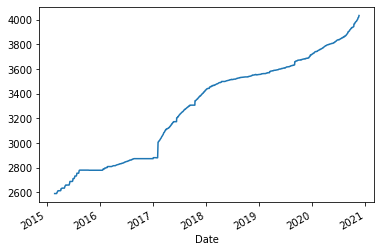

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


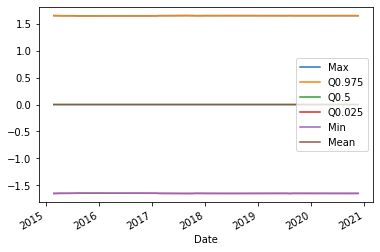

In [21]:
test_alpha_dict({'alpha': alpha})

In [53]:
# lmd * w * alpha[top300] - std(w * rets - index_ret, 150, 'exp', 0.99)

## 中证1000

2016-01-07 24 -0.23502987236295003
2016-01-14 26 -0.1851243896433752
2016-01-21 24 -0.16425668957892103
2016-01-28 26 -0.15324345814626505
2016-02-04 23 -0.1416495976316522
2016-02-18 22 -0.16132876734788504
2016-02-25 23 -0.1762402216753599
2016-03-03 24 -0.15345663015259892
2016-03-10 26 -0.15826038822693655
2016-03-17 23 -0.1744398124490255
2016-03-24 21 -0.18778362018066241
2016-03-31 22 -0.19397929051710383
2016-04-08 22 -0.20624329313467904
2016-04-15 23 -0.22397587682009756
2016-04-22 23 -0.24320342356107894
2016-04-29 23 -0.25364440041747693
2016-05-09 24 -0.26324397458714544
2016-05-16 24 -0.26575113938956446
2016-05-23 26 -0.2765184692173854
2016-05-30 25 -0.2871020074493416
2016-06-06 22 -0.2923617585468187
2016-06-15 22 -0.29157163111676937
2016-06-22 23 -0.300249659534813
2016-06-29 24 -0.31501388864071217
2016-07-06 23 -0.319989638121692
2016-07-13 21 -0.3359032012773444
2016-07-20 22 -0.350164730293412
2016-07-27 21 -0.36050171446948404
2016-08-03 25 -0.35779297825836787

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间
year,,,,,,
2016,0.312432,0.322752,0.203136,1.485518,0.159802,20160108 - 20160128
2017,0.143357,0.146488,0.113073,1.270588,0.097866,20170104 - 20170510
2018,-0.219833,-0.224581,0.188799,-1.257618,0.330692,20180124 - 20181018
2019,0.398542,0.408149,0.207989,1.757448,0.183397,20190417 - 20190606
2020,0.715666,0.738591,0.264092,2.237918,0.14476,20200804 - 20200910
all,1.809019,0.236356,0.201715,1.154537,0.330692,20180124 - 20181018


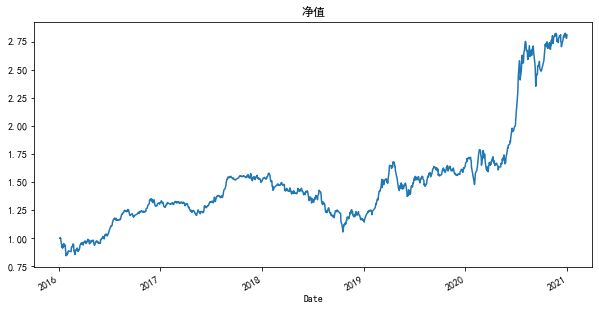

In [74]:
weight_mix, info_mix = gen_opt_weights_mix(rets, idxret['000852-SH'], alpha, reb_date_dt, universe=universe, win=150, decay='exp', coef=0.99, topn=300, maxweight=0.05, lmd=0.4)
bt = Backtest2(weight_mix, rets.loc[datetime(2016, 1, 5):, weight_mix.columns].fillna(0))
bt.run()

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间,跟踪误差
2016,0.357932,0.369953,0.380609,1.018847,0.137212,20160114 - 20160225,0.388700
2017,0.360664,0.369243,0.193445,1.727765,0.083031,20170120 - 20170412,0.193049
2018,0.156471,0.160613,0.307886,0.638201,0.135782,20180208 - 20180417,0.307252
2019,0.058099,0.059319,0.311217,0.340626,0.135818,20190201 - 20190308,0.310579
2020,0.362235,0.372629,0.362582,1.056148,0.133716,20200102 - 20200203,0.361835
all,2.079937,0.259963,0.317341,0.886435,0.17314,20191118 - 20200203,0.319438


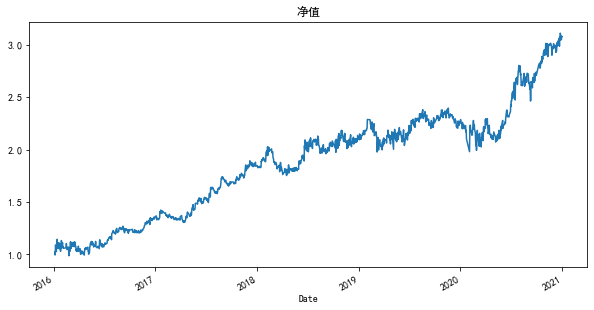

In [76]:
bt.benchmark(idxret['000852-SH']) # 超额收益

## 中证500

2016-01-07 23 -0.2588909012248212
2016-01-14 24 -0.20531970578076675
2016-01-21 24 -0.18806434437773578
2016-01-28 25 -0.17912854720256177
2016-02-04 22 -0.17019693033964356
2016-02-18 22 -0.1901849001383007
2016-02-25 23 -0.202982176107116
2016-03-03 25 -0.1812575201472556
2016-03-10 25 -0.18668265184977195
2016-03-17 23 -0.20222512343294374
2016-03-24 22 -0.21301147099989692
2016-03-31 24 -0.21873521931220452
2016-04-08 28 -0.23168181173219515
2016-04-15 23 -0.2496463159430059
2016-04-22 23 -0.2699788742174868
2016-04-29 22 -0.27995069722468785
2016-05-09 24 -0.29283678502273175
2016-05-16 26 -0.29592909468188
2016-05-23 26 -0.30701053464485106
2016-05-30 25 -0.3169083825856835
2016-06-06 23 -0.3215071822650669
2016-06-15 23 -0.3216707320945046
2016-06-22 23 -0.32949650486807286
2016-06-29 24 -0.34246348274211186
2016-07-06 24 -0.3464288589713455
2016-07-13 22 -0.36262446932546394
2016-07-20 22 -0.37563245142923113
2016-07-27 22 -0.3858609737718976
2016-08-03 23 -0.38448169595911436


,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间
year,,,,,,
2016,0.306531,0.316633,0.200237,1.480812,0.158876,20160108 - 20160128
2017,0.155535,0.158949,0.109597,1.406445,0.081773,20170316 - 20170510
2018,-0.232881,-0.237865,0.186505,-1.368347,0.344662,20180124 - 20181018
2019,0.380907,0.390033,0.207031,1.701741,0.182815,20190417 - 20190606
2020,0.709982,0.73269,0.262662,2.235612,0.142047,20200804 - 20200910
all,1.734775,0.229572,0.199769,1.136214,0.34709,20171121 - 20181018


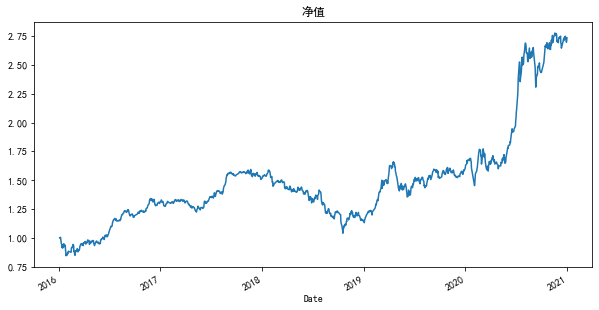

In [77]:
weight_mix, info_mix = gen_opt_weights_mix(rets, idxret['000905-SH'], alpha, reb_date_dt, universe=universe, win=150, decay='exp', coef=0.99, topn=300, maxweight=0.05, lmd=0.4)
bt = Backtest2(weight_mix, rets.loc[datetime(2016, 1, 5):, weight_mix.columns].fillna(0))
bt.run()

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间,跟踪误差
2016,0.341988,0.353408,0.358773,1.025154,0.11967,20160129 - 20160225,0.366760
2017,0.140974,0.144049,0.180224,0.839226,0.092448,20170120 - 20170414,0.179854
2018,0.083242,0.085374,0.297936,0.42375,0.11894,20180212 - 20180417,0.297322
2019,0.044623,0.045554,0.296989,0.298314,0.116098,20190218 - 20190308,0.296380
2020,0.351585,0.361635,0.349069,1.060435,0.125216,20200102 - 20200203,0.348350
all,1.341816,0.191008,0.302784,0.728323,0.169764,20191119 - 20200203,0.304829


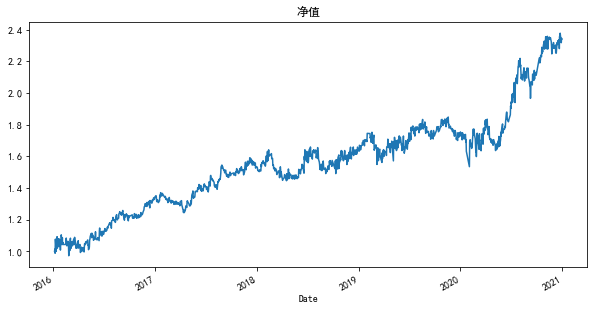

In [78]:
bt.benchmark(idxret['000905-SH'])

## 沪深300

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间
year,,,,,,
2016,0.366801,0.37916,0.191235,1.78507,0.147438,20160108 - 20160128
2017,0.277544,0.283946,0.103778,2.471074,0.064634,20170316 - 20170510
2018,-0.205956,-0.210447,0.183179,-1.203094,0.31403,20180124 - 20181018
2019,0.363303,0.371952,0.205035,1.65214,0.193699,20190417 - 20190606
2020,0.662327,0.683232,0.257574,2.161578,0.14825,20200805 - 20200910
all,2.142205,0.265154,0.194881,1.306375,0.315407,20171121 - 20181018


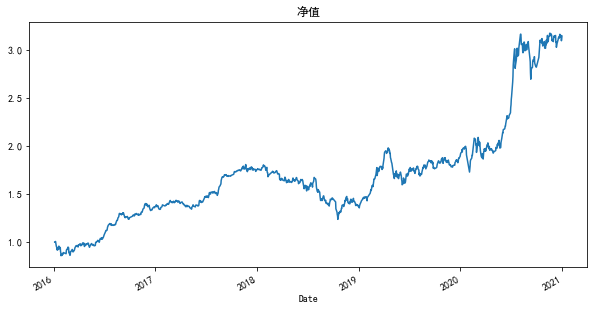

In [116]:
weight_mix, info_mix = gen_opt_weights_mix(rets, idxret['000300-SH'], alpha, reb_date_dt, universe=universe, win=150, decay='exp', coef=0.99, topn=300, maxweight=0.05, lmd=0.4)
bt = Backtest2(weight_mix, rets.loc[datetime(2016, 1, 5):, weight_mix.columns].fillna(0))
bt.run()

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间,跟踪误差
2016,0.374667,0.387326,0.291758,1.27275,0.078995,20160222 - 20160225,0.298765
2017,0.03892,0.03973,0.138406,0.351451,0.066283,20171011 - 20171123,0.138122
2018,0.022368,0.022925,0.276583,0.219828,0.174225,20180712 - 20181023,0.276014
2019,-0.033587,-0.03426,0.266588,0.001494,0.128057,20190416 - 20190614,0.266041
2020,0.272032,0.27958,0.322575,0.927194,0.123851,20200803 - 20200910,0.321911
all,0.794932,0.127684,0.266422,0.58426,0.174225,20180712 - 20181023,0.268063


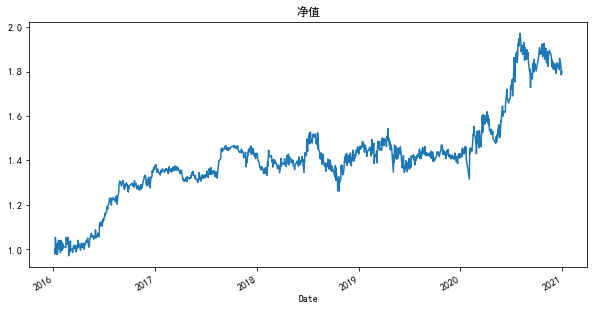

In [117]:
bt.benchmark(idxret['000300-SH'])

# 调参（基于中证500）

## lmd

In [88]:
ann_rtn = []
sharpe = []
for lmd in np.arange(0.1, 1.1, 0.1):
    weight_mix, info_mix = gen_opt_weights_mix(rets, idxret['000905-SH'], alpha, reb_date_dt, universe=universe, win=150, decay='exp', coef=0.99, topn=300, maxweight=0.05, lmd=lmd)
    bt = Backtest2(weight_mix, rets.loc[datetime(2016, 1, 5):, weight_mix.columns].fillna(0))
    bt.run()
    stat = bt.benchmark(idxret['000905-SH'])
    ann_rtn.append(stat.loc['all', '年化收益'])
    sharpe.append(stat.loc['all', '夏普率'])

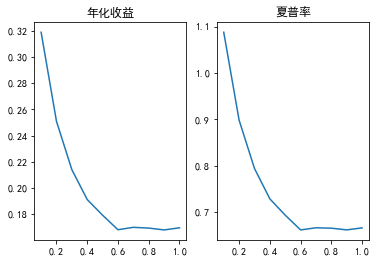

In [90]:
fig = plt.figure()
axis1 = plt.subplot(121, title='年化收益')
axis1.plot(np.arange(0.1, 1.1, 0.1), ann_rtn)
axis2 = plt.subplot(122, title='夏普率')
axis2.plot(np.arange(0.1, 1.1, 0.1), sharpe)

取lmd = 0时效果最好，即仅最小化跟踪误差，不考虑因子暴露

## topn

topn = 100 is finished
topn = 200 is finished
topn = 300 is finished
topn = 400 is finished
topn = 500 is finished
topn = 600 is finished
topn = 700 is finished
topn = 800 is finished
topn = 900 is finished
topn = 1000 is finished


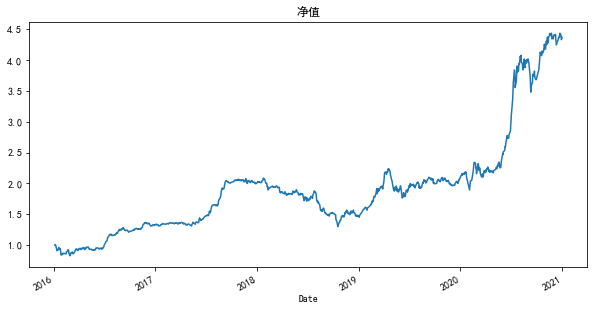

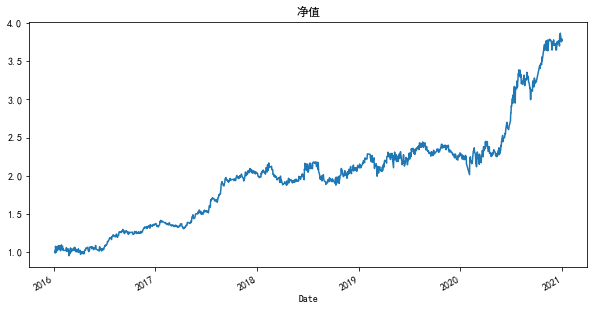

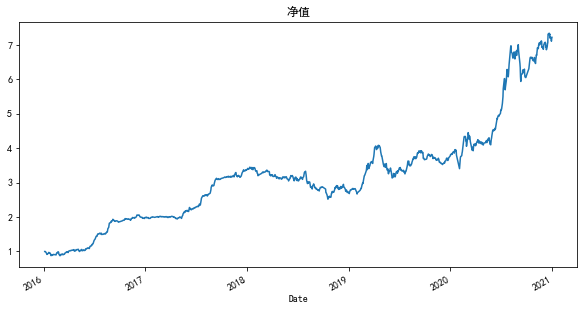

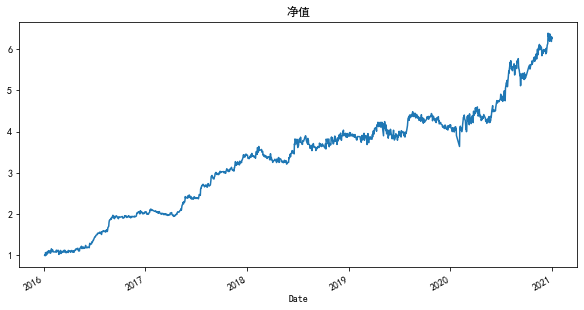

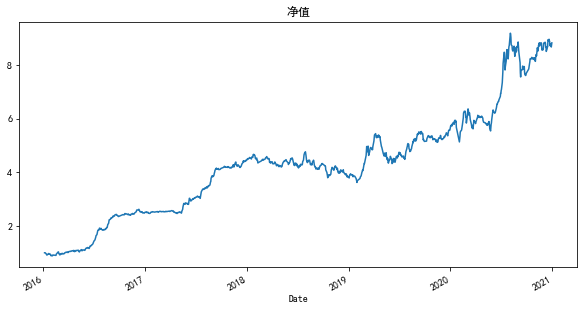

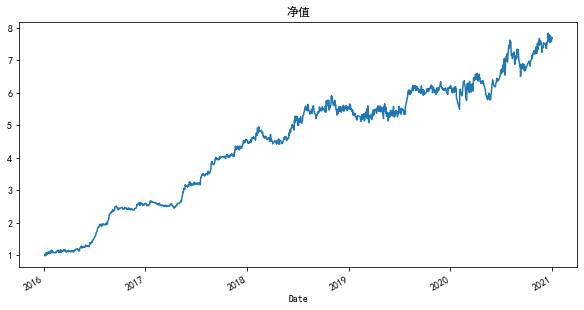

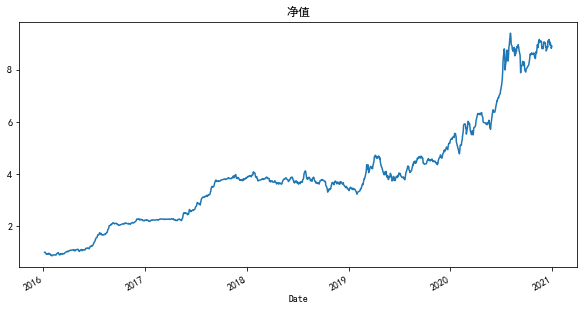

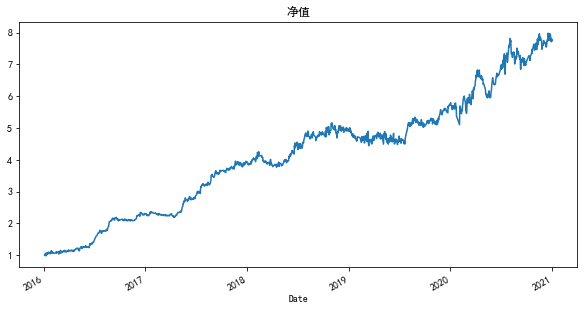

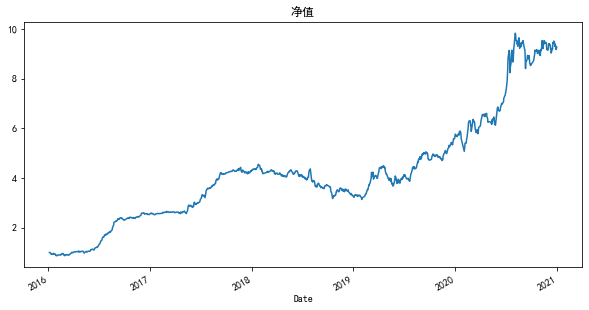

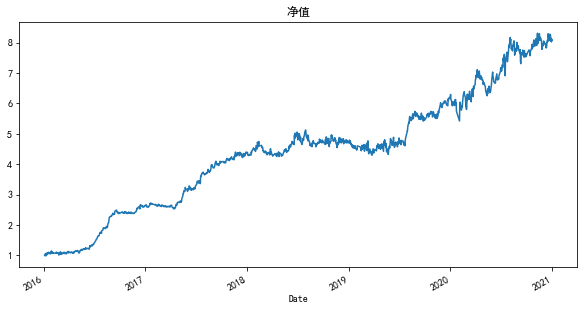

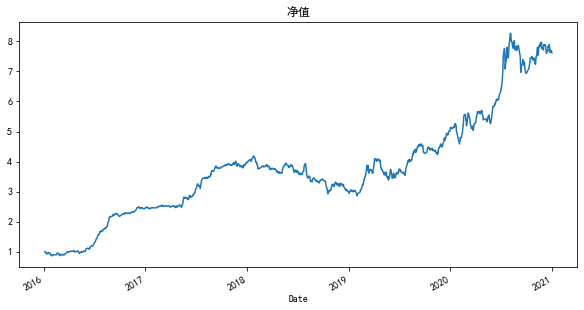

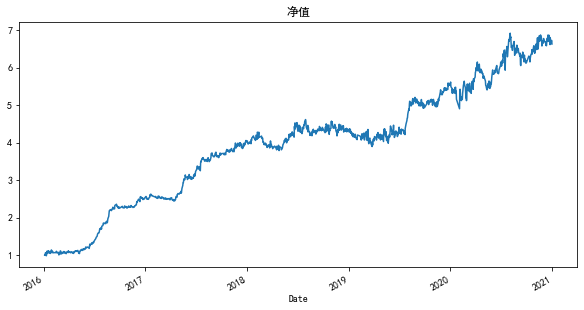

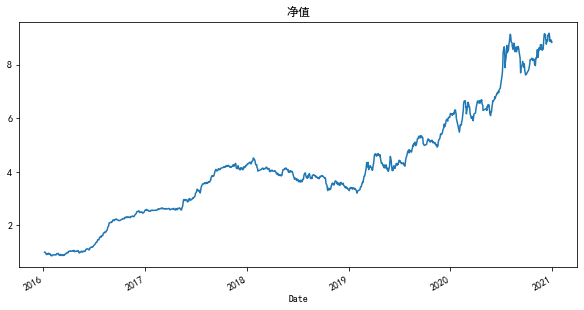

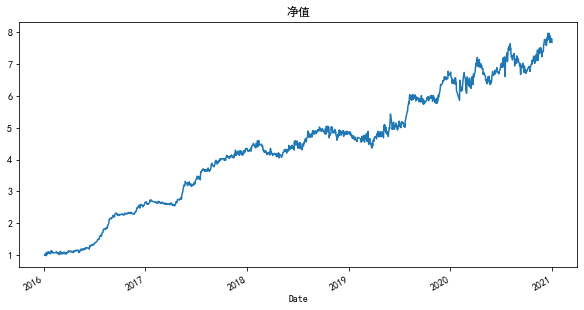

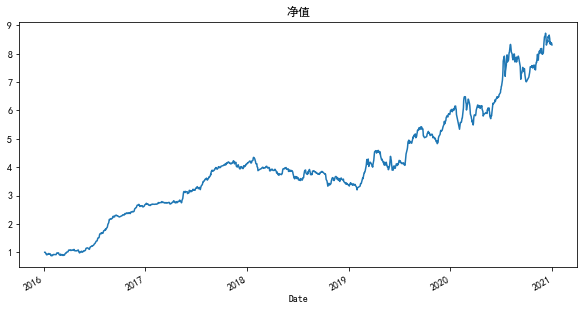

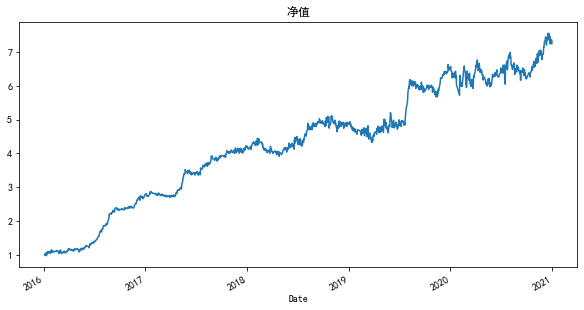

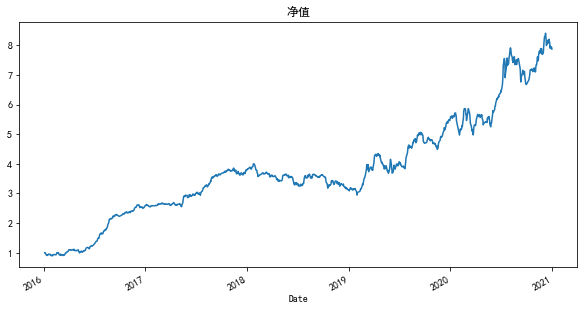

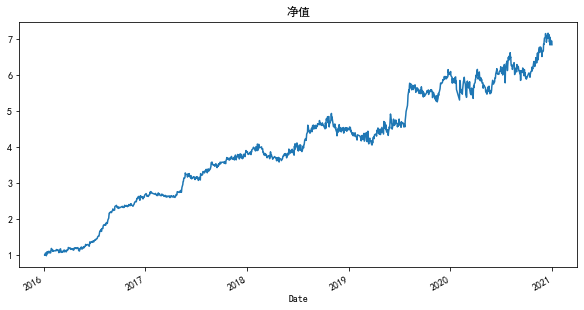

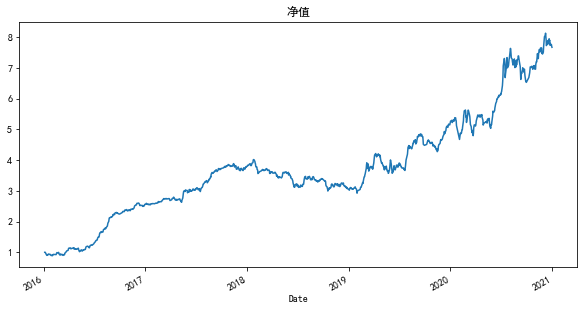

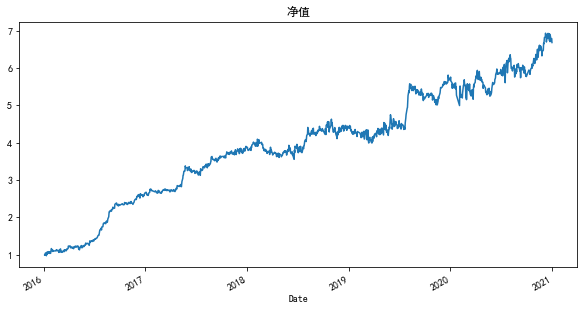

In [277]:
ann_rtn = []
sharpe = []
for topn in np.arange(100, 1100, 100):
    weight_mix, info_mix = gen_opt_weights_mix(rets, idxret['000905-SH'], alpha, reb_date_dt, universe=universe, win=150, decay='exp', coef=0.99, topn=topn, maxweight=0.09, lmd=0.0)
    bt = Backtest2(weight_mix, rets.loc[datetime(2016, 1, 5):, weight_mix.columns].fillna(0))
    bt.run()
    stat = bt.benchmark(idxret['000905-SH'])
    ann_rtn.append(stat.loc['all', '年化收益'])
    sharpe.append(stat.loc['all', '夏普率'])
    print('topn =', topn, 'is finished')

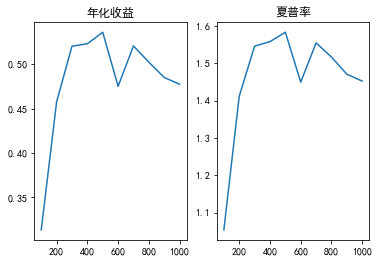

In [278]:
fig = plt.figure()
axis1 = plt.subplot(121, title='年化收益')
axis1.plot(np.arange(100, 1100, 100), ann_rtn)
axis2 = plt.subplot(122, title='夏普率')
axis2.plot(np.arange(100, 1100, 100), sharpe)

取topn = 500时效果最好

## maxweight

maxweight = 0.01 is finished
maxweight = 0.03 is finished
maxweight = 0.049999999999999996 is finished
maxweight = 0.06999999999999999 is finished
maxweight = 0.08999999999999998 is finished
maxweight = 0.10999999999999997 is finished
maxweight = 0.12999999999999998 is finished
maxweight = 0.15 is finished
maxweight = 0.16999999999999998 is finished
maxweight = 0.18999999999999997 is finished


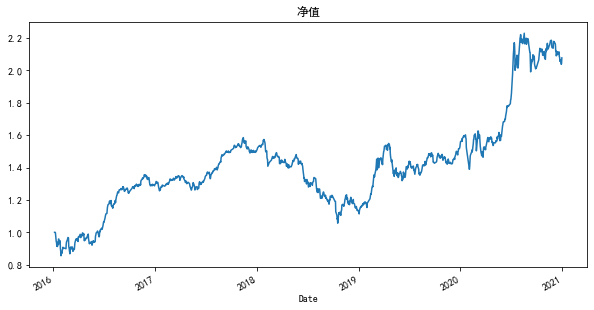

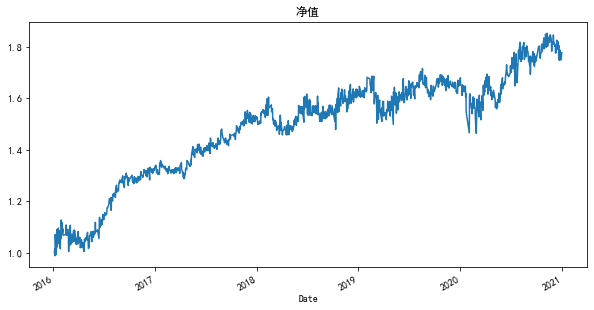

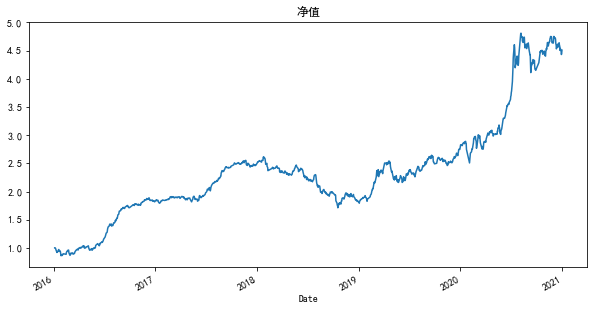

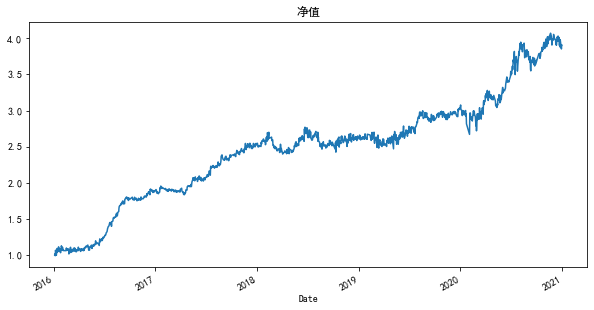

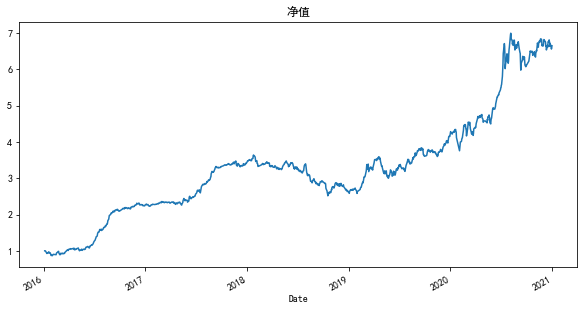

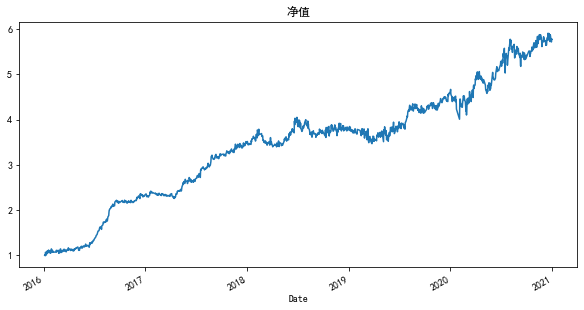

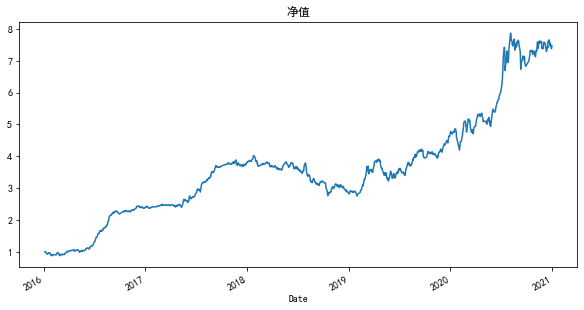

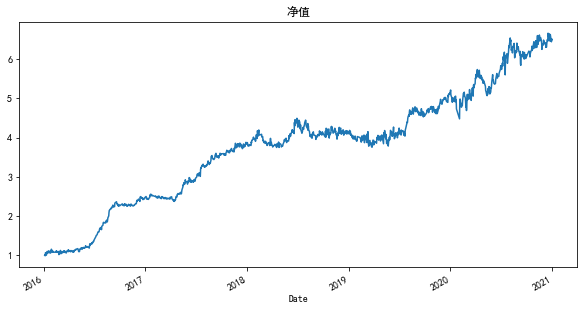

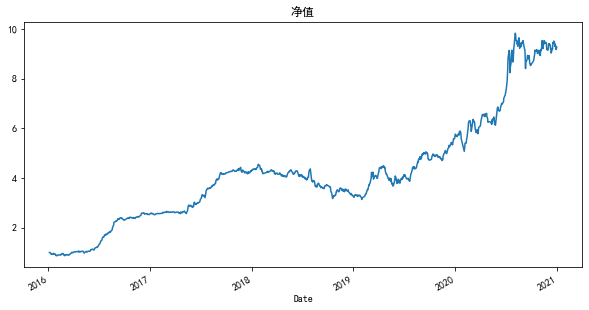

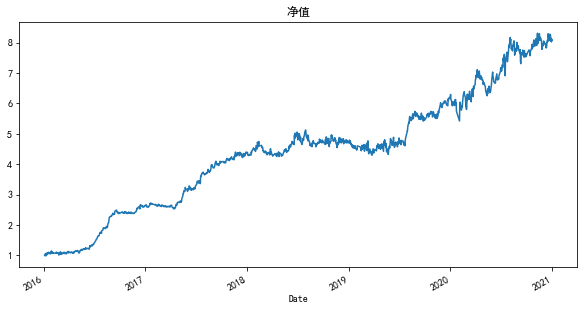

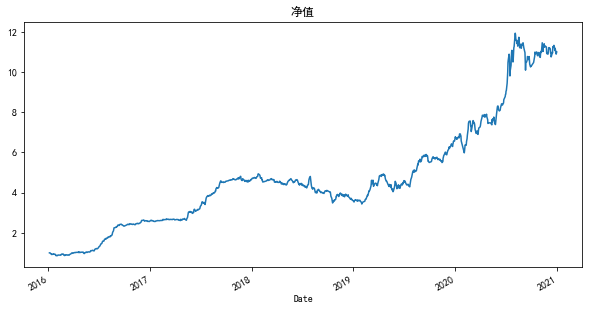

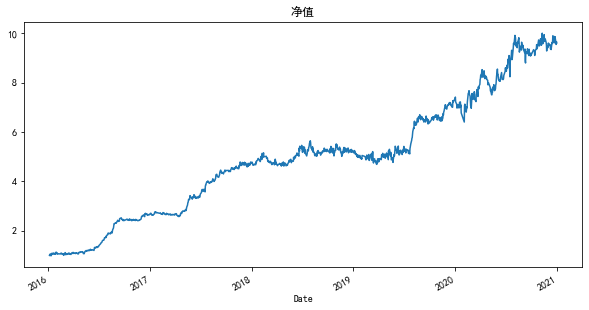

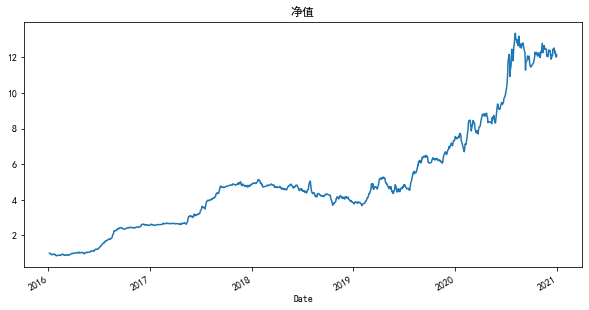

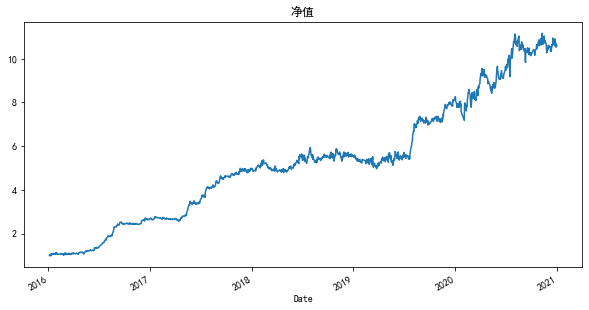

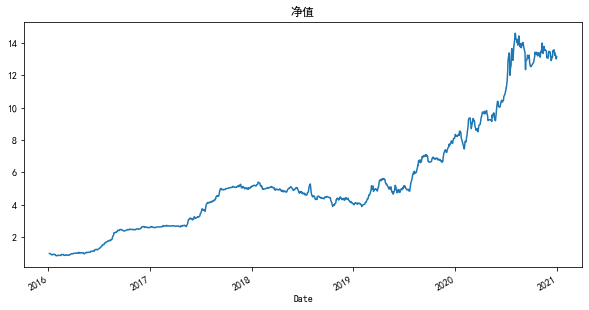

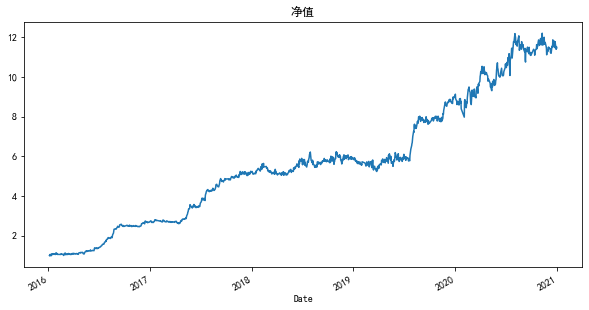

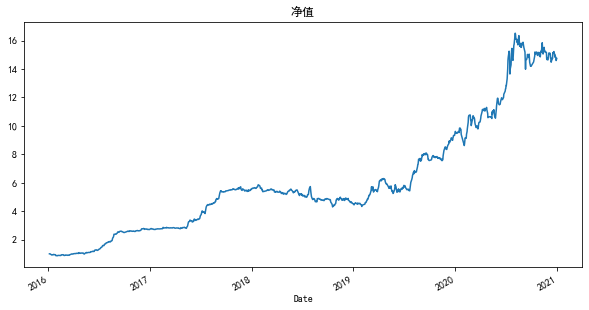

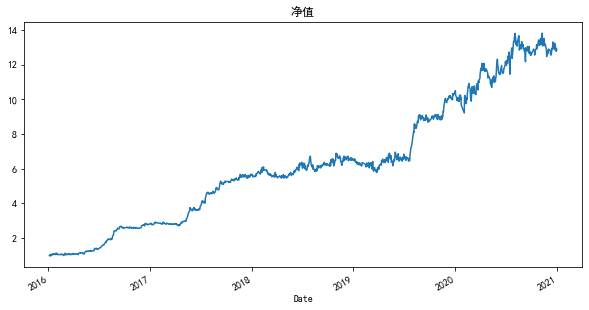

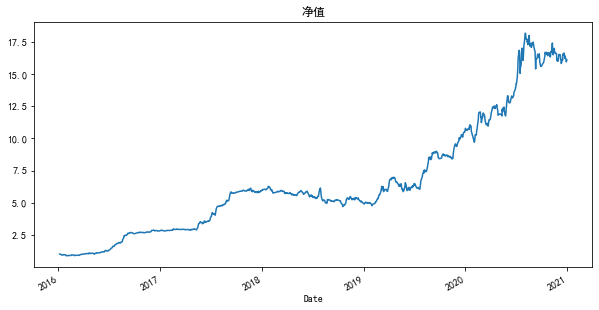

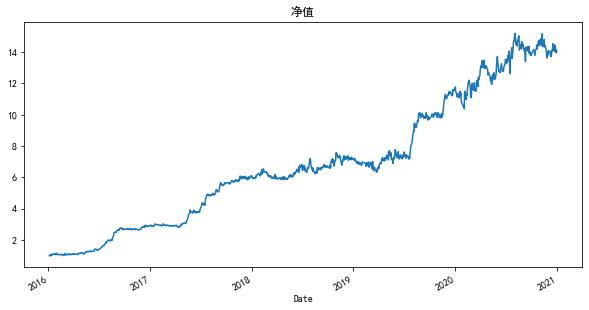

In [280]:
ann_rtn = []
sharpe = []
for maxweight in np.arange(0.01, 0.21, 0.02):
    weight_mix, info_mix = gen_opt_weights_mix(rets, idxret['000905-SH'], alpha, reb_date_dt, universe=universe, win=150, decay='exp', coef=0.99, topn=500, maxweight=maxweight, lmd=0.0)
    bt = Backtest2(weight_mix, rets.loc[datetime(2016, 1, 5):, weight_mix.columns].fillna(0))
    bt.run()
    stat = bt.benchmark(idxret['000905-SH'])
    ann_rtn.append(stat.loc['all', '年化收益'])
    sharpe.append(stat.loc['all', '夏普率'])
    print('maxweight =', maxweight, 'is finished')

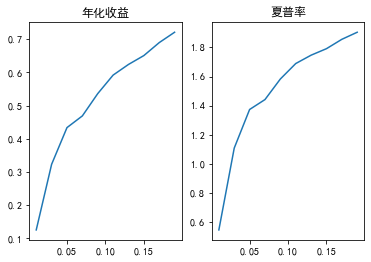

In [281]:
fig = plt.figure()
axis1 = plt.subplot(121, title='年化收益')
axis1.plot(np.arange(0.01, 0.21, 0.02), ann_rtn)
axis2 = plt.subplot(122, title='夏普率')
axis2.plot(np.arange(0.01, 0.21, 0.02), sharpe)

取max_weight = 0.19时效果最好

# 增加换手率限制

In [138]:
values = pd.read_csv('/data-platform/CHN/stock/cooked/Alpha/V0/Matrix/stock/whole_universe/full/interday_pv__2020-12-31__eod_matcher__AdjClose.csv.gz')
values['Date'] = pd.to_datetime(values['Date'])
values = values.set_index('Date')

In [22]:
def turnover_constraint(w, w0, facval, maxtvr):
    w1 = pd.Series(w, index=facval.index)
    w01 = pd.concat([w1, w0], axis=1, ignore_index=False).fillna(0)
    tvr = np.sum(np.abs(np.array(w01[0] - w01[1]))) / 2
    return -tvr + maxtvr

In [23]:
def gen_opt_weights_mix_tvr(fundret, idxret, factor, reb_date, universe=None, win=120, topn=100, maxweight=0.05, decay='exp', coef=0.98, lmd=0.04, maxtvr=0.1):
    if decay is not None:
        decay = cal_decay_w(win, decay, coef)
        
    dimap = dict(zip(fundret.index, range(len(fundret))))

    constraints = [
        {'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint},
        {'type': 'ineq', 'fun': individual_constraint, 'args': (maxweight, False)}
    ]
    
    weight = []
    trackerr = []
    facexpo = []
    for i, opday in enumerate(reb_date):

        day0 = fundret.index[dimap[opday] - win]
        day1 = fundret.index[dimap[opday] - 1]
        if universe is not None:
            facval = (factor.loc[day1] * universe.loc[opday]).dropna()
        else:
            facval = factor.loc[day1].dropna()
        facval = (facval - facval.mean()) / facval.std()
        facval = facval.sort_values(ascending=False).head(topn) # 取因子值最大的topn个股票
        fret = fundret.loc[day0:day1, facval.index].fillna(0)
        iret = idxret.loc[day0:day1]
        w = np.ones(len(facval)) / len(facval)
        
        if i == 0:
            constraints_day = constraints
        else:
            w0 = weight[i - 1]
            constraints_day = constraints + [{'type': 'ineq', 
                                              'fun': turnover_constraint, 
                                              'args': (w0, facval, maxtvr)}]
        
        res = minimize(enhanced_fof_objective, w, 
                       args=(fret, iret, decay, facval, lmd), method='SLSQP', 
                       constraints=constraints_day, tol=1e-10)
        op_w = pd.Series(clean_weight(res.x), index=facval.index)
        print(opday.strftime('%Y-%m-%d'), len(op_w[op_w > 0]), res.fun)
        weight.append(op_w)
        facexpo.append(facval @ res.x)     
        trackerr.append(cal_track_err_w(fret @ res.x, iret, decay))
        
    weight = pd.concat(weight, axis=1).T
    weight.index = reb_date
    weight = weight.fillna(0)
    trackerr = pd.Series(trackerr, index=reb_date, name='trackerr')
    facexpo = pd.Series(facexpo, index=reb_date, name='facexpo')
    info = pd.concat([trackerr, facexpo], axis=1)
    
    return weight, info

## 中证1000

2016-01-07 24 -0.23502987236295003
2016-01-14 24 -0.18475248797441335
2016-01-21 23 -0.16390507771503193
2016-01-28 27 -0.15313992178829205
2016-02-04 23 -0.14164959763050378
2016-02-18 22 -0.16132876734675627
2016-02-25 23 -0.17624022170314657
2016-03-03 24 -0.15343819356806765
2016-03-10 25 -0.1582423563881653
2016-03-17 23 -0.1744398124452351
2016-03-24 21 -0.18778362019876493
2016-03-31 22 -0.19397929051483576
2016-04-08 22 -0.206243293134881
2016-04-15 23 -0.2239758768760085
2016-04-22 23 -0.24320342360273162
2016-04-29 23 -0.2536444004283926
2016-05-09 27 -0.21883735873492755
2016-05-16 27 -0.25010754826847553
2016-05-23 26 -0.27327609922009527
2016-05-30 25 -0.28709081988732754
2016-06-06 22 -0.29236175865504116
2016-06-15 24 -0.29138274954834187
2016-06-22 23 -0.3002496595432046
2016-06-29 24 -0.3150138886272929
2016-07-06 23 -0.31998963815269843
2016-07-13 21 -0.3359032012130278
2016-07-20 22 -0.3501647302637163
2016-07-27 21 -0.36050171447037765
2016-08-03 24 -0.3577876475384

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间
year,,,,,,
2016,0.218035,0.224975,0.200193,1.118798,0.161864,20160108 - 20160128
2017,0.17527,0.17915,0.113078,1.520122,0.098943,20170104 - 20170510
2018,-0.257266,-0.262678,0.187114,-1.540725,0.337569,20180124 - 20181018
2019,0.381612,0.390757,0.210803,1.677515,0.189509,20190417 - 20190606
2020,0.528348,0.544373,0.26102,1.804598,0.154131,20200803 - 20200910
all,1.245119,0.180736,0.200517,0.930307,0.338165,20171121 - 20181018


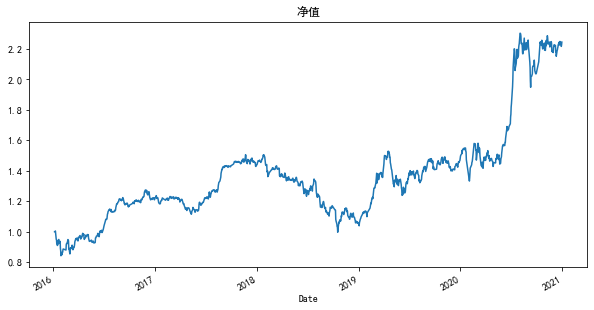

In [266]:
weight_mix, info_mix = gen_opt_weights_mix_tvr(rets, idxret['000852-SH'], alpha, reb_date_dt, universe=universe, win=150, decay='exp', coef=0.99, topn=300, maxweight=0.05, lmd=0.4, maxtvr=0.1)
bt = Backtest2(weight_mix, rets.loc[datetime(2016, 1, 5):, weight_mix.columns].fillna(0))
bt.run()

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间,跟踪误差
2016,0.260159,0.268581,0.379264,0.817362,0.137998,20160114 - 20160225,0.387464
2017,0.398564,0.408171,0.193686,1.871329,0.082973,20170120 - 20170412,0.193289
2018,0.099949,0.102529,0.310288,0.469364,0.133454,20180208 - 20180417,0.309649
2019,0.044312,0.045237,0.316131,0.297673,0.135284,20190201 - 20190308,0.315482
2020,0.213913,0.219713,0.35909,0.732294,0.134601,20200803 - 20200909,0.358351
all,1.457525,0.202866,0.317682,0.739597,0.178783,20191114 - 20200228,0.319787


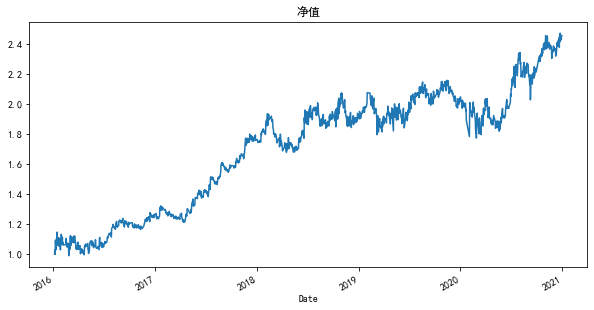

In [267]:
bt.benchmark(idxret['000852-SH'])

## 中证500

In [37]:
alpha = pd.read_csv('/Users/liupeilin/Desktop/AlphaNet/v2/MSE_alpha/Y2/alpha_in&out_by_industry.csv')
alpha['Date'] = pd.to_datetime(alpha['Date'])
alpha = alpha.set_index('Date')

alpha = winsorize(alpha)
alpha = zscore(alpha)
alpha = alpha.iloc[1:]
print(alpha.shape)

(1399, 4186)


In [47]:
test = pd.read_csv('/Users/liupeilin/Desktop/股票数据/index.csv')
test = test.iloc[1:]
print(test.shape)
# test['period'] = np.arange(1461) % 5
# test = test[(test['period'] == 1) & (test['Date'] > '2018-10-30')]
test = test[(test['Date'] > '2018-10-30') & (test['Date'] <= '2020-11-19')]
reb_date_dt = pd.to_datetime(sorted(test['Date'].values))

(1461, 6)


In [48]:
reb_date_dt

DatetimeIndex(['2018-10-31', '2018-11-01', '2018-11-02', '2018-11-05',
               '2018-11-06', '2018-11-07', '2018-11-08', '2018-11-09',
               '2018-11-12', '2018-11-13',
               ...
               '2020-11-06', '2020-11-09', '2020-11-10', '2020-11-11',
               '2020-11-12', '2020-11-13', '2020-11-16', '2020-11-17',
               '2020-11-18', '2020-11-19'],
              dtype='datetime64[ns]', length=500, freq=None)

In [49]:
weight_mix, info_mix = gen_opt_weights_mix_tvr(rets, idxret['000905-SH'], alpha, reb_date_dt, universe=universe, win=150, decay='exp', coef=0.99, topn=500, maxweight=0.05, lmd=0.0, maxtvr=0.1)

2018-10-31 134 0.0039895578193173305
2018-11-01 213 0.02661349972134983
2018-11-02 213 0.01883607199178299
2018-11-05 219 0.016300913350102732
2018-11-06 208 0.017427820249374205
2018-11-07 181 0.021149747045509107
2018-11-08 183 0.01791923843652284
2018-11-09 189 0.018527621494550207
2018-11-12 187 0.016562840793135074
2018-11-13 184 0.016035982788391485
2018-11-14 194 0.01612987172473646
2018-11-15 206 0.01270150646235199
2018-11-16 202 0.013739648374303874
2018-11-19 212 0.011536398057368119
2018-11-20 216 0.011311571884997191
2018-11-21 209 0.01596990393084842
2018-11-22 212 0.016022316828883987
2018-11-23 212 0.015302666108207763
2018-11-26 193 0.016172776541007253
2018-11-27 194 0.013010812825164845
2018-11-28 191 0.013957982099816002
2018-11-29 203 0.012605835817763845
2018-11-30 204 0.016611756450041877
2018-12-03 188 0.016736605636119468
2018-12-04 180 0.01717473913116125
2018-12-05 173 0.01775710171872153
2018-12-06 175 0.01737660215605044
2018-12-07 175 0.015593264622375818


In [50]:
import joblib
joblib.dump(weight_mix, '150, exp, 0.99, 500, 0.05, 0.0, 0.1.pkl')

['150, exp, 0.99, 500, 0.05, 0.0, 0.1.pkl']

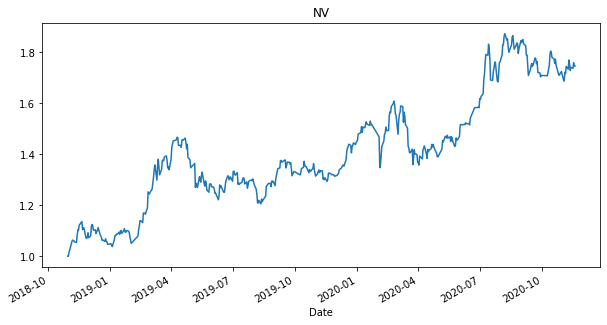

In [92]:
bt = Backtest2(weight_mix, rets.loc[datetime(2018, 10, 30):datetime(2020, 11, 19), weight_mix.columns].fillna(0))
stats, nav = bt.run()

In [66]:
nav

Date
2018-10-30    1.000000
2018-10-31    1.000000
2018-11-01    1.017397
2018-11-02    1.024554
2018-11-05    1.055803
                ...   
2020-11-13    1.741120
2020-11-16    1.737994
2020-11-17    1.759345
2020-11-18    1.746513
2020-11-19    1.745975
Name: 组合净值, Length: 501, dtype: float64

In [68]:
stats

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间
year,,,,,,
2018,0.046332,0.293476,0.224469,1.283296,0.078934,20181120 - 20181228
2019,0.382616,0.391788,0.227378,1.574322,0.178472,20190410 - 20190812
2020,0.206888,0.245677,0.2543,0.99618,0.156035,20200225 - 20200402
all,0.745975,0.320619,0.238542,1.288572,0.178472,20190410 - 20190812


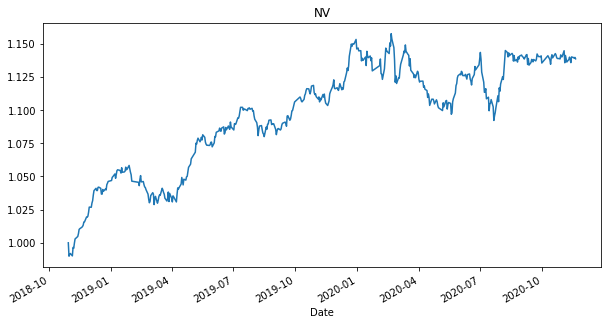

In [93]:
ex_stats, ex_nav = bt.benchmark(idxret['000905-SH'])

In [87]:
ex_stats

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间,跟踪误差
2018,0.046215,0.292654,0.041515,6.350728,0.010094,20181030 - 20181031,0.055084
2019,0.095297,0.097333,0.044102,2.137054,0.027849,20190128 - 20190306,0.044012
2020,-0.006452,-0.007533,0.061728,-0.092333,0.056457,20200220 - 20200721,0.061583
all,0.138522,0.066877,0.052296,1.266631,0.056457,20200220 - 20200721,0.053491


## 沪深300

2016-01-07 22 -0.32063859743800066
2016-01-14 22 -0.27373727629656563
2016-01-21 24 -0.26265165028221893
2016-01-28 25 -0.2577954389800958
2016-02-04 23 -0.25022304545101126
2016-02-18 24 -0.2666950552268935
2016-02-25 22 -0.2851132850138422
2016-03-03 24 -0.26982816409380467
2016-03-10 23 -0.2793508414340729
2016-03-17 23 -0.2962901829310716
2016-03-24 21 -0.3055656817707518
2016-03-31 23 -0.31054916906155694
2016-04-08 24 -0.323249808162692
2016-04-15 25 -0.34027184817246653
2016-04-22 22 -0.361893186184149
2016-04-29 23 -0.36725308124780287
2016-05-09 33 -0.3365555307828935
2016-05-16 27 -0.37096378937603125
2016-05-23 26 -0.3946892190252345
2016-05-30 26 -0.40674836597499997
2016-06-06 23 -0.4076272371996922
2016-06-15 25 -0.4080004351500795
2016-06-22 25 -0.4168847793764945
2016-06-29 24 -0.43006018639101057
2016-07-06 23 -0.4315084338745889
2016-07-13 23 -0.44507545730482306
2016-07-20 23 -0.45510876266645667
2016-07-27 22 -0.463269039619637
2016-08-03 24 -0.46704965615353
2016-0

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间
year,,,,,,
2016,0.317187,0.327683,0.191493,1.583229,0.14758,20160108 - 20160128
2017,0.278262,0.284682,0.104961,2.449864,0.069727,20170316 - 20170510
2018,-0.24562,-0.250831,0.182057,-1.500874,0.315578,20180124 - 20181018
2019,0.33978,0.347802,0.208525,1.542378,0.213002,20190417 - 20190606
2020,0.558645,0.575749,0.251571,1.943087,0.147033,20200805 - 20200910
all,1.652396,0.22187,0.194031,1.131524,0.315578,20180124 - 20181018


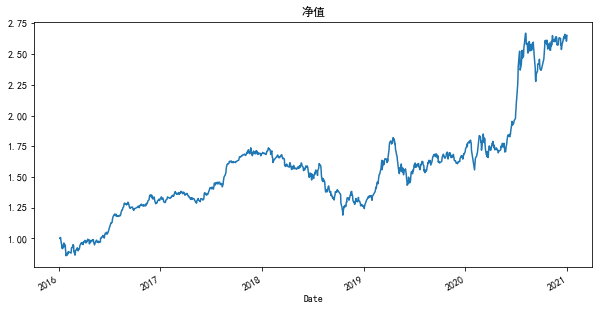

In [268]:
weight_mix, info_mix = gen_opt_weights_mix_tvr(rets, idxret['000300-SH'], alpha, reb_date_dt, universe=universe, win=150, decay='exp', coef=0.99, topn=300, maxweight=0.05, lmd=0.4, maxtvr=0.1)
bt = Backtest2(weight_mix, rets.loc[datetime(2016, 1, 5):, weight_mix.columns].fillna(0))
bt.run()

,收益,年化收益,波动率,夏普率,最大回撤,最大回撤区间,跟踪误差
2016,0.324588,0.335358,0.292428,1.13923,0.07904,20160222 - 20160225,0.299450
2017,0.039486,0.040308,0.139453,0.353814,0.067836,20170103 - 20170602,0.139167
2018,-0.028911,-0.029612,0.276839,0.028676,0.17442,20180712 - 20181018,0.276269
2019,-0.050546,-0.05155,0.270334,-0.061862,0.145909,20190416 - 20190614,0.269780
2020,0.191866,0.197021,0.319713,0.722985,0.136874,20200803 - 20200909,0.319055
all,0.513072,0.088798,0.266771,0.452158,0.19437,20180712 - 20200203,0.268417


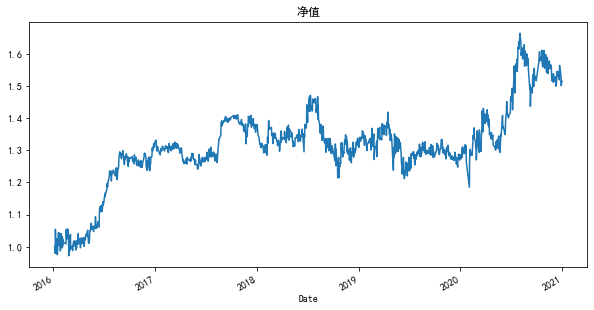

In [269]:
bt.benchmark(idxret['000300-SH'])